CONTAGION 
NODE BLOCKING
ERDOS-RENYI GRAPH


In [1]:
import matplotlib.pyplot as plt
from networkx import nx
import numpy as np
import algorithmx
import random
import pandas as pd
from collections import defaultdict

n = 100  # number of nodes
#m = int(((n*(n-1))/2)*(0.08)) # number of edges
m= 400

high_infected_percentage=0.15
medium_infected_percentage=0.1
low_infected_percentage=0.05

high_risky_percentage=0.5
medium_risky_percentage=0.3
low_risky_percentage=0.1


infected_percentage=medium_infected_percentage
total_risky_percentage=1-infected_percentage
risky_percentage=medium_risky_percentage

total_infected=int(infected_percentage*n)
total_risky=int(risky_percentage*n)

G = nx.gnm_random_graph(n, m)

colnames=range(1,(n+1))
adjacency_df = pd.DataFrame(np.zeros((n,n)),columns=colnames,index=colnames)

for (u, v) in G.edges():
    G.edges[u,v]['weight'] = np.random.uniform(0,1)
    adjacency_df.iat[u,v]=G.edges[u,v]['weight']
    adjacency_df.iat[v,u]=G.edges[u,v]['weight']

#nx.draw(G)
#plt.show()
dummy_vector=np.arange(1,n+1)
dummy_selected=np.random.choice(dummy_vector,(total_infected+total_risky),replace=False)
selected_infected=np.random.choice(dummy_selected,total_infected,replace=False)
selected_risky= [i for i in dummy_selected if i not in selected_infected]

adjacency_df['Threshold']=np.random.uniform(0,1,size=n) #Tekrar bak ...
adjacency_df['IsInfected']=np.zeros((n,1))
adjacency_df['IsRisky']=np.zeros((n,1))
adjacency_df.loc[selected_infected,'IsInfected']=1
adjacency_df.loc[selected_risky,'IsRisky']=1

adjacency_df.to_csv("adjacency_df-n"+str(n)+'-m'+str(m)+".csv",index=False)

#sets
setV = range(1,n+1)


In [2]:
#sets
setS = adjacency_df.loc[(adjacency_df.loc[:, "IsInfected"] < 1),"IsInfected"].index.tolist()
setP = adjacency_df.loc[(adjacency_df.loc[:, "IsInfected"] > 0),"IsInfected"].index.tolist()
setRisky= adjacency_df.loc[(adjacency_df.loc[:, "IsRisky"] > 0),"IsRisky"].index.tolist()

In [3]:
Blocking_Capacity = (int(n/10))

In [4]:
def simulate_LTM(removed_nodes,Graph_for_simulation,setP):
    G=Graph_for_simulation.copy()
    for i in removed_nodes:           
        G.remove_node(i)
    converted_list=setP.copy()   
    while(1):
        converted_list1 = converted_list[:]
        for node in G.nodes():
            if (node) not in converted_list: 
                total_weight = 0
                for each in G.neighbors(node):
                    if (each) in converted_list:
                        total_weight = total_weight + adjacency_df.at[node,each]
                if total_weight > adjacency_df.at[node,'Threshold']:
                    converted_list.append(node)         
        if set(converted_list1) == set(converted_list):
            break
    objective_value=adjacency_df.loc[converted_list,'IsRisky'].sum()
    return objective_value 

In [5]:
def convert(a):      
    rows, cols = np.where(a.loc[range(1,n+1), range(1,n+1)] > 0)
    edges = zip((rows+1).tolist(), (cols+1).tolist())
    G = nx.Graph()
    G.add_edges_from(edges)

    return G

In [6]:
nonconnected_nodes=adjacency_df.loc[adjacency_df.loc[:,range(1,n+1)].sum(axis=0)==0,:].index
for i in nonconnected_nodes:
    adjacency_df.at[i,i]=1

In [7]:
Graph = convert(adjacency_df)

In [8]:
total_rows=100000
all_columns=setS+['Objective']
df_for_dm = pd.DataFrame(np.zeros((total_rows,(n-total_infected+1))),columns=all_columns,index=range(1,total_rows+1))
for i in range(1,total_rows+1):
    solution_vector=np.random.choice(setS,Blocking_Capacity,replace=False)
    df_for_dm.at[i,'Objective']=simulate_LTM(solution_vector,Graph,setP)
    df_for_dm.loc[i,solution_vector]=1
    

In [77]:
total_rows_test=1000
all_columns_test=setS+['Objective']
df_for_dm_test = pd.DataFrame(np.zeros((total_rows_test,(n-total_infected+1))),columns=all_columns_test,index=range(1,total_rows_test+1))
for i in range(1,total_rows_test+1):
    solution_vector_test=np.random.choice(setS,Blocking_Capacity,replace=False)
    df_for_dm_test.at[i,'Objective']=simulate_LTM(solution_vector_test,Graph,setP)
    df_for_dm_test.loc[i,solution_vector_test]=1
    

In [12]:
df_for_dm['Objective'].min()

21.0

In [14]:
df_for_dm.to_excel('df_for_dm.xlsx')

In [58]:
InputVars=df_for_dm.iloc[:,:-1]
Target=df_for_dm.iloc[:,-1]
InputVars=InputVars.astype("category")

In [80]:
InputVars_test=df_for_dm_test.iloc[:,:-1]
Target_test=df_for_dm_test.iloc[:,-1]

InputVars_test=InputVars_test.astype("category")

In [72]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree

from sklearn.ensemble import AdaBoostRegressor



In [68]:
clf = DecisionTreeRegressor(random_state=0,min_impurity_decrease=0.01)

In [69]:
clf.fit(InputVars,Target)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.01, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

AttributeError: 'AdaBoostRegressor' object has no attribute 'tree_'

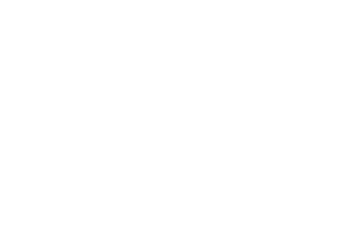

In [78]:
tree.plot_tree(clf)
plt.savefig('Tree_2.pdf')
plt.show()


In [101]:
tree_predictions_on_train=clf.predict(InputVars)
tree_predictions_on_test=clf.predict(InputVars_test)

In [102]:
mape_tree_train=abs((tree_predictions_on_train-Target)/Target).sum()/total_rows
mape_tree_test=abs((tree_predictions_on_test-Target_test)/Target_test).sum()/total_rows_test
print(mape_tree_train)
mape_tree_test

0.038310929728744114


0.038392482501043886

In [76]:


regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4,min_impurity_decrease=0.01),
                          n_estimators=100, random_state=492)


regr_2.fit(InputVars, Target)


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=4,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.01,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
                 

In [90]:
adaboost_predictions_on_train=regr_2.predict(InputVars)
adaboost_predictions_on_test=regr_2.predict(InputVars_test)

In [99]:
mape_adaboost_train=abs((adaboost_predictions_on_train-Target)/Target).sum()/total_rows
mape_adaboost_test=abs((adaboost_predictions_on_test-Target_test)/Target_test).sum()/total_rows_test
print(mape_adaboost_train)
mape_adaboost_test

0.030179165640581127


0.030073109986657815

In [117]:
(adaboost_predictions_on_test-Target_test).describe()

count    1000.000000
mean        0.435907
std         0.834174
min        -2.259562
25%        -0.298839
50%         0.562618
75%         1.070944
max         2.861830
Name: Objective, dtype: float64

In [118]:
Target_test.describe()

count    1000.000000
mean       26.471000
std         1.391077
min        22.000000
25%        26.000000
50%        26.000000
75%        27.000000
max        30.000000
Name: Objective, dtype: float64

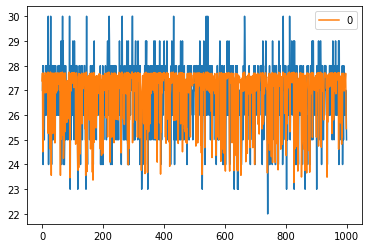

In [120]:
ax =Target_test.plot()
adaboost_predictions_on_test=pd.DataFrame(adaboost_predictions_on_test)
adaboost_predictions_on_test.plot(ax=ax)
plt.sav()


In [122]:
import seaborn as sns


Text(0.5, 0, 'fractal dimension se')

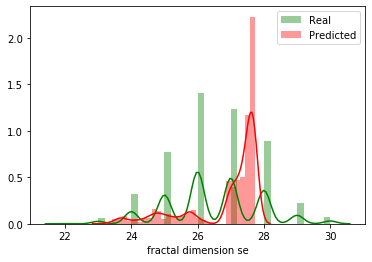

In [124]:
sns.distplot(Target_test, color='green', label='Real')
sns.distplot(adaboost_predictions_on_test, color='red', label='Predicted')
plt.legend(loc='best')
plt.xlabel('fractal dimension se')


Text(0, 0.5, 'symmetry worst')

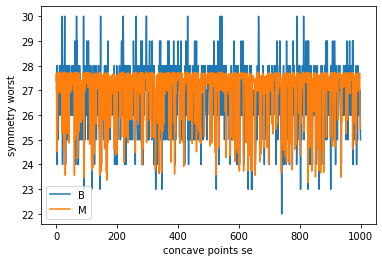

In [125]:
plt.plot(Target_test,my_manipulated_data_B.symmetry_worst,"m*")
plt.plot(my_manipulated_data_M["concave points_se"],my_manipulated_data_M.symmetry_worst,"g^")
plt.legend(["B","M"])
plt.xlabel("concave points se")
plt.ylabel("symmetry worst")


C:\Users\Lenovo\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


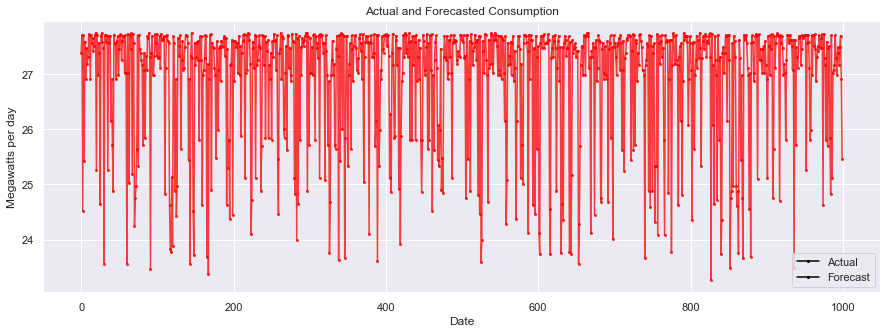

In [129]:
sns.set(rc={'figure.figsize':(15, 5)})
error=Target_test-adaboost_predictions_on_test
plt.plot(error,color="black", marker="o",markersize=2)
plt.plot(adaboost_predictions_on_test,color="red",marker="o",markersize=2,alpha=0.75)

plt.title("Actual and Forecasted Consumption")
plt.ylabel("Megawatts per day")
plt.xlabel("Date")
plt.legend(['Actual', 'Forecast']);


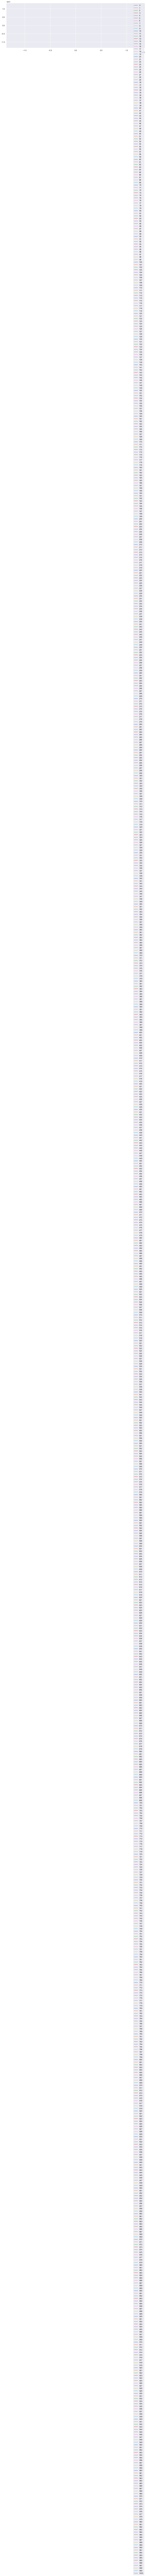

In [132]:
error.plot()
plt.show()